In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import animation
from matplotlib.animation import PillowWriter
import scienceplots
plt.style.use(['science', 'notebook'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Define number of particles and get random positions (between 0 and 1) for each particle 

In [2]:
n_particles = 16
r = torch.rand((2, n_particles)).to(device)

In [3]:
r

tensor([[0.8696, 0.9049, 0.5395, 0.3760, 0.6444, 0.0621, 0.3636, 0.0535, 0.3263,
         0.2818, 0.6773, 0.8874, 0.2313, 0.2520, 0.9764, 0.4461],
        [0.5958, 0.6169, 0.8683, 0.1821, 0.9291, 0.6066, 0.4032, 0.4643, 0.5660,
         0.5334, 0.9341, 0.8779, 0.3578, 0.3667, 0.7934, 0.0262]],
       device='cuda:0')

Color particles based on position (blue if they belong on the lefthand side; red if they are on the righthand side)

In [4]:
ixr = r[0] >  0.5   # right
ixl = r[0] <= 0.5   # left

In [5]:
ixr

tensor([ True,  True,  True, False,  True, False, False, False, False, False,
         True,  True, False, False,  True, False], device='cuda:0')

Give IDs to each particle

In [6]:
ids = torch.arange(n_particles)

Plot initial configuration of particles

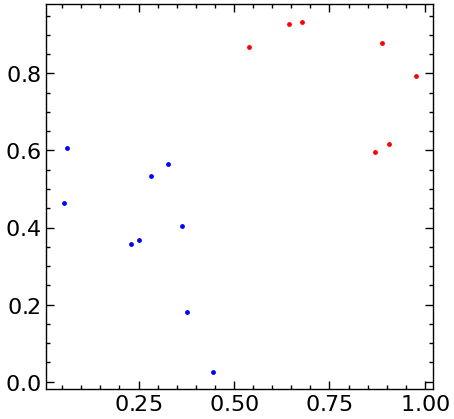

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(r[0][ixr].cpu(), r[1][ixr].cpu(), color='r', s=6)
plt.scatter(r[0][ixl].cpu(), r[1][ixl].cpu(), color='b', s=6)

Obtain the initial velocities in the gas. We'll make the particles starting on the RHS move to the left at 500m/s and on the vice versa.

* **Note**: We're using the assumption that particles in a gas move at approximately 500m/s, thanks google.

In [8]:
v = torch.zeros((2, n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] =  500

To run this simulation, we need to determine when two particles collide, and what the resulting final velocities will be.

# Part 1: Distance Between all Pairs

* To determine if two particles collide, we need to find the distance between **all pairs** of particles. If the distance is less than 2 times the radius of each particle, they collide. If there are $n$ particles, there are $n(n-1)/2$ pairs (combinatorics). To make this easier, we'll get pairs of particle IDs.

In [9]:
ids_pairs = torch.combinations(ids, 2).to(device)
#ids_pairs

We can obtain distances between particles in a similar fashion

* First get the pairs of x-positions of all particles 

In [10]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
x_pairs

tensor([[0.8696, 0.9049],
        [0.8696, 0.5395],
        [0.8696, 0.3760],
        [0.8696, 0.6444],
        [0.8696, 0.0621],
        [0.8696, 0.3636],
        [0.8696, 0.0535],
        [0.8696, 0.3263],
        [0.8696, 0.2818],
        [0.8696, 0.6773],
        [0.8696, 0.8874],
        [0.8696, 0.2313],
        [0.8696, 0.2520],
        [0.8696, 0.9764],
        [0.8696, 0.4461],
        [0.9049, 0.5395],
        [0.9049, 0.3760],
        [0.9049, 0.6444],
        [0.9049, 0.0621],
        [0.9049, 0.3636],
        [0.9049, 0.0535],
        [0.9049, 0.3263],
        [0.9049, 0.2818],
        [0.9049, 0.6773],
        [0.9049, 0.8874],
        [0.9049, 0.2313],
        [0.9049, 0.2520],
        [0.9049, 0.9764],
        [0.9049, 0.4461],
        [0.5395, 0.3760],
        [0.5395, 0.6444],
        [0.5395, 0.0621],
        [0.5395, 0.3636],
        [0.5395, 0.0535],
        [0.5395, 0.3263],
        [0.5395, 0.2818],
        [0.5395, 0.6773],
        [0.5395, 0.8874],
        [0.5

* Then take the difference to get $\Delta x_{ij}$ of all pairs

In [11]:
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dx_pairs

tensor([ 0.0353, -0.3301, -0.4936, -0.2252, -0.8075, -0.5060, -0.8161, -0.5433,
        -0.5878, -0.1923,  0.0178, -0.6383, -0.6176,  0.1068, -0.4234, -0.3654,
        -0.5289, -0.2605, -0.8428, -0.5413, -0.8514, -0.5786, -0.6231, -0.2276,
        -0.0175, -0.6736, -0.6529,  0.0715, -0.4588, -0.1635,  0.1049, -0.4774,
        -0.1759, -0.4860, -0.2132, -0.2577,  0.1378,  0.3479, -0.3082, -0.2875,
         0.4369, -0.0933,  0.2684, -0.3140, -0.0125, -0.3225, -0.0498, -0.0943,
         0.3012,  0.5113, -0.1447, -0.1241,  0.6004,  0.0701, -0.5824, -0.2809,
        -0.5909, -0.3182, -0.3627,  0.0329,  0.2430, -0.4131, -0.3925,  0.3320,
        -0.1983,  0.3015, -0.0086,  0.2642,  0.2197,  0.6152,  0.8253,  0.1692,
         0.1899,  0.9144,  0.3841, -0.3101, -0.0373, -0.0818,  0.3137,  0.5238,
        -0.1322, -0.1116,  0.6129,  0.0826,  0.2728,  0.2283,  0.6238,  0.8339,
         0.1778,  0.1985,  0.9229,  0.3926, -0.0445,  0.3510,  0.5611, -0.0949,
        -0.0743,  0.6502,  0.1199,  0.39

The total distance is just $d_{ij}= \sqrt{\Delta x_{ij}^2 + \Delta y_{ij}^2}$. Since there are $n(n-1)/2$ pairs, there will be $n(n-1)/2$ different values of $d_{ij}$.

In [12]:
x_pairs = torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T
y_pairs = torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T
dx_pairs = torch.diff(x_pairs, axis=1).ravel()
dy_pairs = torch.diff(y_pairs, axis=1).ravel()
d_pairs = torch.sqrt(dx_pairs**2 + dy_pairs**2)
d_pairs

tensor([0.0411, 0.4280, 0.6440, 0.4023, 0.8076, 0.5414, 0.8266, 0.5441, 0.5911,
        0.3892, 0.2827, 0.6812, 0.6587, 0.2247, 0.7097, 0.4435, 0.6846, 0.4066,
        0.8429, 0.5820, 0.8650, 0.5809, 0.6287, 0.3905, 0.2617, 0.7217, 0.6992,
        0.1905, 0.7479, 0.7054, 0.1213, 0.5445, 0.4972, 0.6320, 0.3699, 0.4226,
        0.1527, 0.3480, 0.5963, 0.5782, 0.4433, 0.8472, 0.7938, 0.5279, 0.2214,
        0.4285, 0.3871, 0.3637, 0.8101, 0.8635, 0.2276, 0.2224, 0.8568, 0.1709,
        0.6657, 0.5962, 0.7519, 0.4828, 0.5368, 0.0332, 0.2483, 0.7050, 0.6859,
        0.3587, 0.9244, 0.3637, 0.1426, 0.2673, 0.2316, 0.6970, 0.8688, 0.3009,
        0.3060, 0.9333, 0.6959, 0.3160, 0.1670, 0.1537, 0.6167, 0.7069, 0.1398,
        0.1174, 0.7265, 0.3859, 0.2911, 0.2385, 0.7810, 0.9309, 0.2072, 0.2212,
        0.9799, 0.5883, 0.0552, 0.5086, 0.6420, 0.2288, 0.2127, 0.6888, 0.5529,
        0.5630, 0.6968, 0.1827, 0.1694, 0.7417, 0.5331, 0.2175, 0.7287, 0.7091,
        0.3306, 0.9369, 0.8372, 0.8156, 

# Part 2: Velocities of a Collision
So at each iteration of the simulation, we will evaluate `d_pairs`, and if any of the distances between particles is less than $2r$, then a collision occurs. What is the final velocity of each of the two spheres? In an elastic collision (conservation of energy + momentum + angular momentum), one can show

$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

In [13]:
radius = 0.06
ids_pairs_collide = ids_pairs[d_pairs < 2*radius]
ids_pairs_collide

tensor([[ 0,  1],
        [ 4, 10],
        [ 6, 13],
        [ 8,  9],
        [12, 13]], device='cuda:0')

In [14]:
v1 = v[:, ids_pairs_collide[:,0]]
v2 = v[:, ids_pairs_collide[:,1]]
r1 = r[:, ids_pairs_collide[:,0]]
r2 = r[:, ids_pairs_collide[:,1]]

Then we can compute the new velocity:

In [15]:
v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)

# Part 3: Functions to Run the Simulation

Here we define some functions that will help make running the simulation easier.

In [16]:
def get_deltad2_pairs(r, ids_pairs):
    dx = torch.diff(torch.stack([r[0][ids_pairs[:,0]], r[0][ids_pairs[:,1]]]).T).squeeze()
    dy = torch.diff(torch.stack([r[1][ids_pairs[:,0]], r[1][ids_pairs[:,1]]]).T).squeeze()
    return dx**2 + dy**2

def compute_new_v(v1, v2, r1, r2):
    v1new = v1 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2new = v2 - torch.sum((v1-v2)*(r1-r2), axis=0)/torch.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1new, v2new

def motion(r, v, id_pairs, ts, dt, d_cutoff):
    rs = torch.zeros((ts, r.shape[0], r.shape[1])).to(device)
    vs = torch.zeros((ts, v.shape[0], v.shape[1])).to(device)
    # Initial State
    rs[0] = r
    vs[0] = v
    for i in range(1,ts):
        ic = id_pairs[get_deltad2_pairs(r, ids_pairs) < d_cutoff**2]
        v[:,ic[:,0]], v[:,ic[:,1]] = compute_new_v(v[:,ic[:,0]], v[:,ic[:,1]], r[:,ic[:,0]], r[:,ic[:,1]])
        
        v[0,r[0]>1] = -torch.abs(v[0,r[0]>1])
        v[0,r[0]<0] = torch.abs(v[0,r[0]<0])
        v[1,r[1]>1] = -torch.abs(v[1,r[1]>1])
        v[1,r[1]<0] = torch.abs(v[1,r[1]<0])
        
        r = r + v*dt
        rs[i] = r
        vs[i] = v
    return rs, vs

Set the radius and find the position of all particles as a function of time (3D array `rs` where each axis is $(t,x,y)$).

In [17]:
radius = 0.03
rs, vs = motion(r, v, ids_pairs, ts=1000, dt=8e-6, d_cutoff=2*radius)

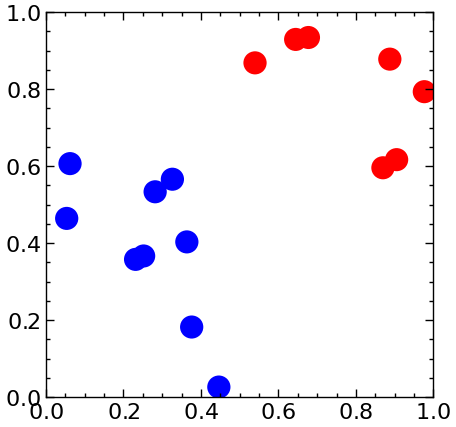

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
xred, yred = rs[0][0][ixr], rs[0][1][ixr]
xblue, yblue = rs[0][0][ixl],rs[0][1][ixl]
circles_red = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xred,yred)]
circles_blue = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(xblue,yblue)]
cred = matplotlib.collections.PatchCollection(circles_red, facecolors='red')
cblue = matplotlib.collections.PatchCollection(circles_blue, facecolors='blue')
ax.add_collection(cred)
ax.add_collection(cblue)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

Make initial animation of the simulation

Make sure that 'ffmpeg' is installed. For Ubuntu use:
> sudo apt-get install ffmpeg

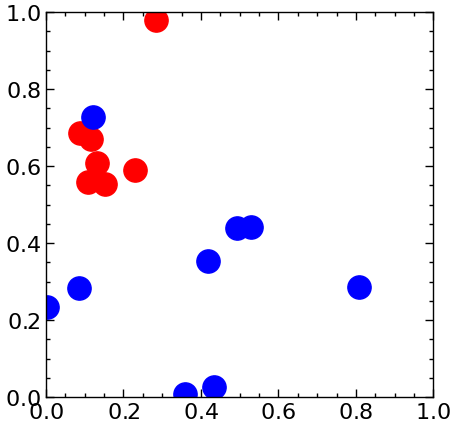

In [19]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.clear()
vmin = 0
vmax = 1
ax.set_xlim(0,1)
ax.set_ylim(0,1)
markersize = 2 * radius * ax.get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = ax.plot([], [], 'o', color='red', markersize=markersize)
blue, = ax.plot([], [], 'o', color='blue', markersize=markersize)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani3.mp4',writer=writer,dpi=100)

Now that we're sure that it works, lets make a simulation containing many more particles

In [21]:
n_particles = 5000
r = torch.rand((2, n_particles)).to(device)
ixr = r[0] >  0.5
ixl = r[0] <= 0.5
ids = torch.arange(n_particles)
ids_pairs = torch.combinations(ids, 2).to(device)
v = torch.zeros((2, n_particles)).to(device)
v[0][ixr] = -500
v[0][ixl] =  500
radius = 5e-4
rs, vs = motion(r, v, ids_pairs, ts=1000, dt = 8e-6, d_cutoff=2*radius)


Let's look at the final velocity distribution of the particles and compare it to Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

In [22]:
v = np.linspace(0, 2000, 1000)
a = 2.0/500.0**2
fv = a*v*np.exp(-a*v**2 / 2)

Text(0, 0.5, '# Particles')

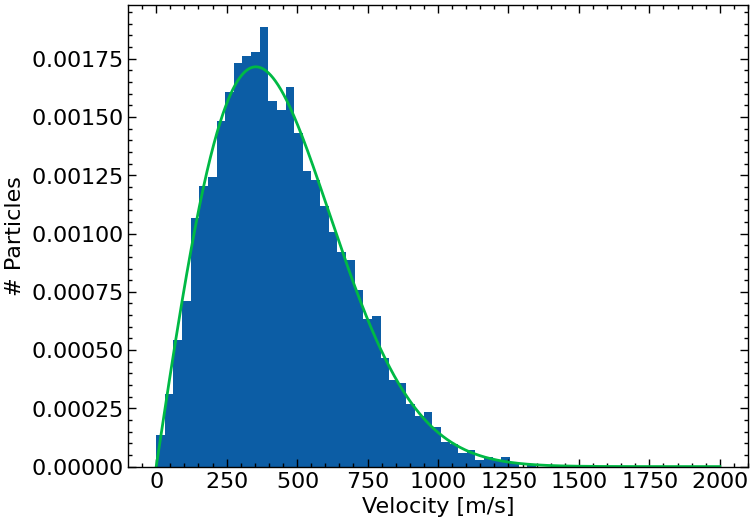

In [23]:
bins = np.linspace(0,1500,50)
plt.figure()
plt.hist(torch.sqrt(torch.sum(vs[-1]**2, axis=0)).cpu(), bins=bins, density=True)
plt.plot(v,fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')

Finally, we can make an animation of the particles moving around and the histogram at the same time

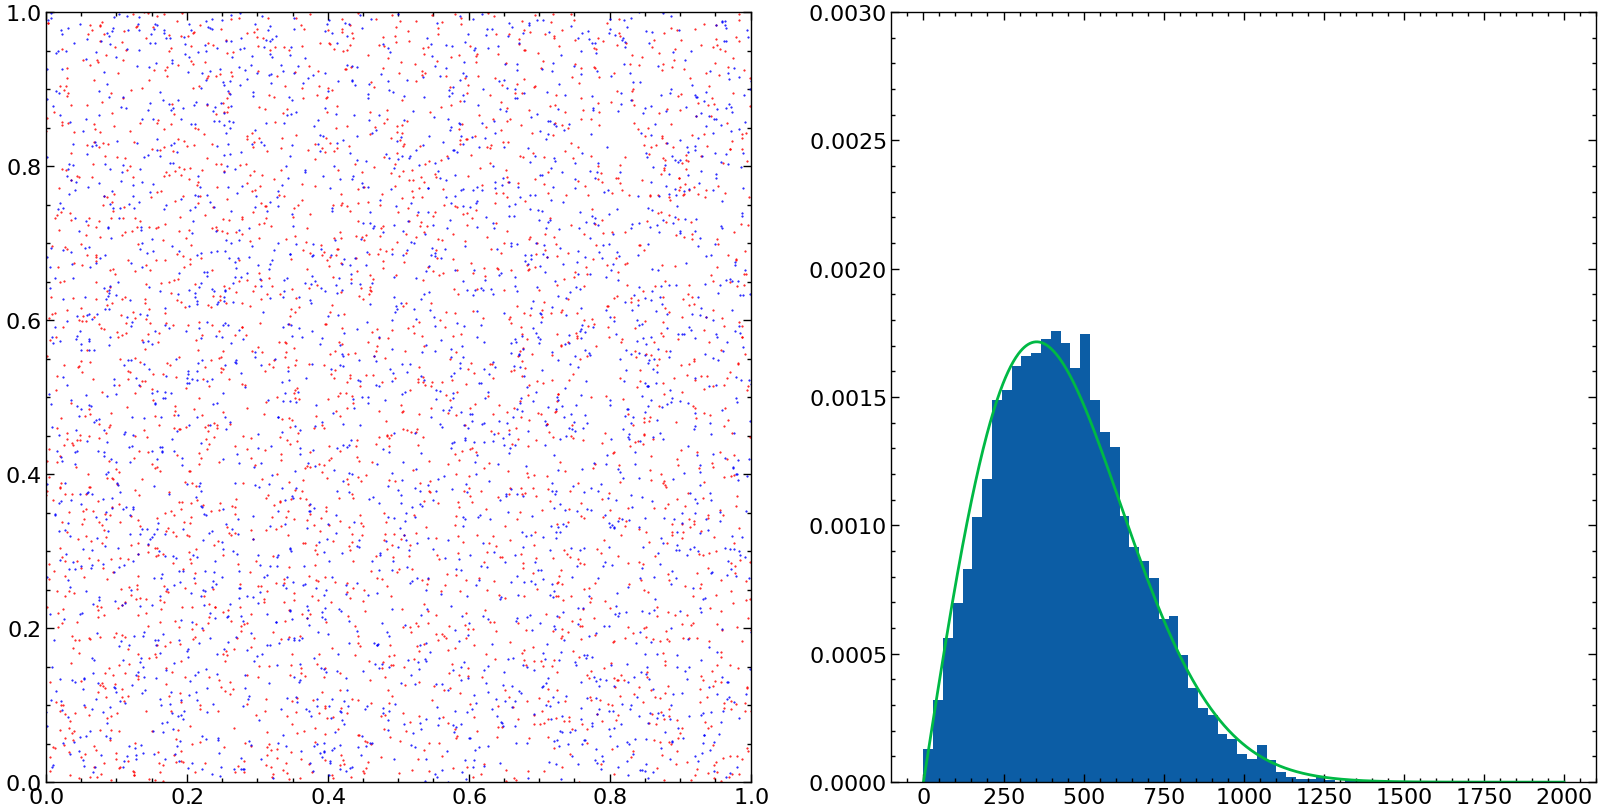

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20,10))
axes[0].clear()
vmin = 0
vmax = 1
axes[0].set_xlim(0,1)
axes[0].set_ylim(0,1)
markersize = 2 * radius * axes[0].get_window_extent().width  / (vmax-vmin) * 72./fig.dpi
red, = axes[0].plot([], [], 'o', color='red', markersize=markersize)
blue, = axes[0].plot([], [], 'o', color='blue', markersize=markersize)
n, bins, patches = axes[1].hist(torch.sqrt(torch.sum(vs[0]**2, axis=0)).cpu(), bins=bins, density=True)
axes[1].plot(v,fv)
axes[1].set_ylim(top=0.003)

def animate(i):
    xred, yred = rs[i][0][ixr].cpu(), rs[i][1][ixr].cpu()
    xblue, yblue = rs[i][0][ixl].cpu(),rs[i][1][ixl].cpu()
    red.set_data(xred, yred)
    blue.set_data(xblue, yblue)
    hist, _ = np.histogram(torch.sqrt(torch.sum(vs[i]**2, axis=0)).cpu(), bins=bins, density=True)
    for i, patch in enumerate(patches):
        patch.set_height(hist[i])
    return red, blue

writer = animation.FFMpegWriter(fps=30)
ani = animation.FuncAnimation(fig, animate, frames=500, interval=50, blit=True)
ani.save('ani_gpu_10000.mp4',writer=writer,dpi=100)